In [4]:
# !unzip /content/Test.zip

In [2]:
# Test Path 
testPath = 'Test'

# In colob testPath is 
# testPath = 'content/Test'

In [3]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import feature
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from itertools import chain
from sklearn.metrics import accuracy_score  # or f1_score, etc.
from sklearn.metrics import classification_report

In [4]:
from utils import create_images_list
from pca_helper import prepare_data, process_test_images 

In [5]:
suffix = '.pgm'
kaggle_files = os.listdir(testPath)
pgm_kaggle_files = [filename for filename in kaggle_files if filename.endswith(suffix)]

In [6]:
len(pgm_kaggle_files)

8000

In [7]:
kaggle_patches = []
for filename in tqdm(pgm_kaggle_files):
  path = testPath + '/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  kaggle_patches.append(image)

  0%|          | 0/8000 [00:00<?, ?it/s]

100%|██████████| 8000/8000 [00:01<00:00, 5903.00it/s]


In [8]:
pgm_kaggle_files_id = []

for filename in tqdm(pgm_kaggle_files):
  pgm_kaggle_files_id.append(filename[5:-4])

100%|██████████| 8000/8000 [00:00<00:00, 1992070.29it/s]


# Preprocesamiento de los datos

Obtenemos Faces y backgorunds

In [9]:
facesPath = 'Faces' # use '/content/Faces' on colab
faces = create_images_list([facesPath])
faces.shape

100%|██████████| 12833/12833 [00:02<00:00, 5777.61it/s]


(12833, 64, 64)

In [10]:
from constants import (BACKGROUND_PATH)
backgrounds = create_images_list([BACKGROUND_PATH])
backgrounds.shape


100%|██████████| 12800/12800 [00:02<00:00, 4422.90it/s]


(12800, 64, 64)

# PCA

In [14]:
X_train_pca, X_test, y_train, y_test, scaler, pca = prepare_data(faces, backgrounds, test_size=0.3, random_state=42, use_hog=False)

Construyendo X: 25633it [00:00, 425423.47it/s]


In [15]:
# print shape of X_train_pca, X_test, y_train, y_test, scaler, pca
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"scaler shape: {scaler}")
print(f"pca shape: {pca}")

X_train_pca shape: (17943, 500)
X_test shape: (7690, 4096)
y_train shape: (17943,)
y_test shape: (7690,)
scaler shape: StandardScaler()
pca shape: PCA(n_components=500)


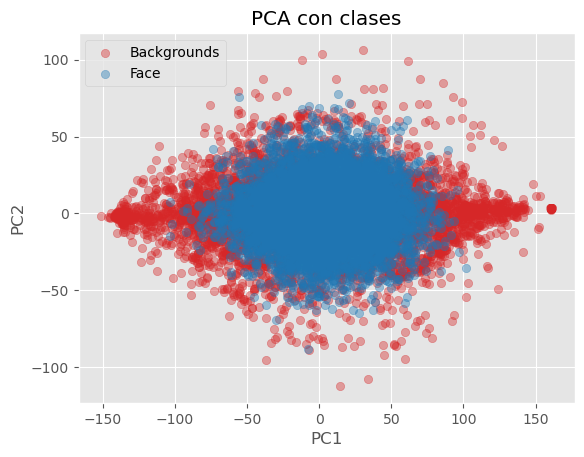

In [18]:
# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Backgrounds', 'Face']

for class_value in [0, 1]:
    plt.scatter(
        X_train_pca[y_train == class_value, 0],
        X_train_pca[y_train == class_value, 1],
        c=colors[class_value],
        label=labels[class_value],
        alpha=0.4
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
gaussianModel = GaussianNB()
gaussianModel.fit(X_train_pca, y_train)

GaussianNB()

In [14]:
y_train_pred = gaussianModel.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = gaussianModel.predict(X_test_pca)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.41      0.51      8990
         1.0       0.57      0.80      0.67      8953

    accuracy                           0.60     17943
   macro avg       0.62      0.60      0.59     17943
weighted avg       0.62      0.60      0.59     17943

              precision    recall  f1-score   support

         0.0       0.67      0.41      0.51      3810
         1.0       0.58      0.80      0.67      3880

    accuracy                           0.61      7690
   macro avg       0.62      0.60      0.59      7690
weighted avg       0.62      0.61      0.59      7690



In [15]:
X_pca_kag = process_test_images(kaggle_patches, scaler, pca, use_hog=False)
# Predicción
y_kag = gaussianModel.predict(X_pca_kag)

# Evaluate
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = gaussianModel.predict(X_test_pca)
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)

Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:00<00:00, 133070.13it/s]


Validation Accuracy: 0.606371911573472


In [16]:
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)
kaggle_hat.head()

In [18]:
# Guardamos en un .csv para subir a kaggle
submission_name = 'pca_submition'
kaggle_hat.to_csv(submission_name + '.csv', index=False)

# Kaggle result

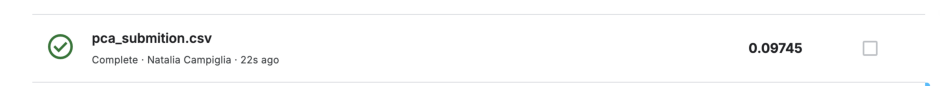

In [ ]:
import matplotlib.pyplot as plt

img = plt.imread('kaggle_submissions/pca_submition.png')
plt.figure(figsize=(12, 12)) 
plt.imshow(img)
plt.axis('off')
plt.show()

# HOG

In [19]:
# use prepare_data to get X_train_pca, X_test, y_train, y_test, scaler, pca
X_train_pca, X_test, y_train, y_test, scaler, pca = prepare_data(faces, backgrounds, test_size=0.3, random_state=42)

Construyendo X: 25633it [00:23, 1078.99it/s]


In [20]:
# print shape of X_train_pca, X_test, y_train, y_test, scaler, pca
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"scaler shape: {scaler}")
print(f"pca shape: {pca}")

X_train_pca shape: (17943, 500)
X_test shape: (7690, 2916)
y_train shape: (17943,)
y_test shape: (7690,)
scaler shape: StandardScaler()
pca shape: PCA(n_components=500)


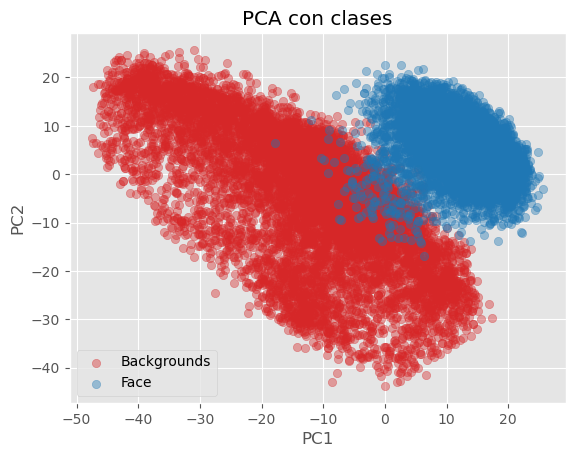

In [21]:
# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Backgrounds', 'Face']

for class_value in [0, 1]:
    plt.scatter(
        X_train_pca[y_train == class_value, 0],
        X_train_pca[y_train == class_value, 1],
        c=colors[class_value],
        label=labels[class_value],
        alpha=0.4
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
gaussianModel = GaussianNB()
gaussianModel.fit(X_train_pca, y_train)
y_train_pred = gaussianModel.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = gaussianModel.predict(X_test_pca)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      8990
         1.0       0.97      0.94      0.95      8953

    accuracy                           0.96     17943
   macro avg       0.96      0.96      0.96     17943
weighted avg       0.96      0.96      0.96     17943

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95      3810
         1.0       0.98      0.93      0.95      3880

    accuracy                           0.95      7690
   macro avg       0.95      0.95      0.95      7690
weighted avg       0.96      0.95      0.95      7690



In [26]:
X_pca_kag = process_test_images(kaggle_patches, scaler, pca)
# Predicción
y_kag = gaussianModel.predict(X_pca_kag)

# Evaluate
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = gaussianModel.predict(X_test_pca)
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)

Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:06<00:00, 1143.45it/s]


Validation Accuracy: 0.9540962288686606


In [27]:
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)
kaggle_hat.head()

,id,target_feature
2069,0,0
2527,1,0
3030,2,0
2576,3,0
4060,4,0


In [29]:
# Guardamos en un .csv para subir a kaggle
submission_name = 'hog_submition'
kaggle_hat.to_csv(submission_name + '.csv', index=False)

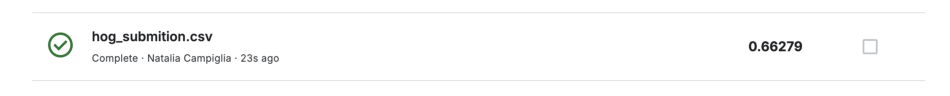

In [1]:
import matplotlib.pyplot as plt

img = plt.imread('kaggle_submissions/hog_submission.png')
plt.figure(figsize=(12, 12)) 
plt.imshow(img)
plt.axis('off')
plt.show()

# Models

In [11]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report

In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


### Random Forest

Random Forest es una excelente elección para este problema de clasificación de imágenes por varias razones:

1. **Manejo de Dimensionalidad**: 
   - Después de aplicar PCA, nuestros datos siguen teniendo 500 dimensiones
   - Random Forest maneja bien datos de alta dimensionalidad sin necesidad de normalización adicional
   - Cada árbol en el bosque puede seleccionar diferentes subconjuntos de características

2. **Robustez**:
   - Es menos propenso al overfitting que modelos individuales
   - La combinación de múltiples árboles reduce la varianza
   - Maneja bien el ruido en los datos de imágenes

3. **Características no lineales**:
   - Puede capturar relaciones no lineales entre características
   - Importante para reconocimiento de patrones en imágenes
   - No requiere transformaciones adicionales de los datos

4. **Interpretabilidad**:
   - Proporciona importancia de características
   - Permite entender qué aspectos de las imágenes son más relevantes
   - Útil para análisis y mejoras del modelo

5. **Rendimiento**:
   - Como vemos en los resultados, alcanza una precisión del 98% en el conjunto de validación
   - Buen balance entre precisión y recall para ambas clases
   - F1-score de 0.98 indica un buen equilibrio entre precisión y recall

6. **Eficiencia computacional**:
   - Entrenamiento paralelizable
   - Predicciones rápidas
   - Escalable a grandes conjuntos de datos

7. **Manejo de desbalanceo**:
   - Puede manejar clases desbalanceadas
   - Útil si las clases de imágenes no están perfectamente balanceadas
   - Permite ajustar pesos de clases si es necesario

In [13]:
X_train_pca, X_test, y_train, y_test, scaler, pca = prepare_data(faces, backgrounds, test_size=0.3, random_state=42)

Construyendo X: 25633it [00:13, 1835.04it/s]


In [44]:
from sklearn.ensemble import RandomForestClassifier

# Define el modelo base
rf = RandomForestClassifier(random_state=42)
# Define la grilla de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 15, 30],
    'max_features': ['sqrt', 'log2']
}

# Configura GridSearchCV
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',   # o 'accuracy'
    n_jobs=-1,
    verbose=2
)

# Entrena
grid_rf.fit(X_train_pca, y_train)

print("Mejores hiperparámetros:", grid_rf.best_params_)
print("Mejor AUC (CV):", grid_rf.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time= 1.3min
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time= 1.4min
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time= 1.4min
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time= 1.4min
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time= 1.4min
[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time= 2.4min
[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time= 2.4min
[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time= 2.4min
[CV] END .max_depth=None, max_features=log2, n_estimators=50; total time=  27.6s
[CV] END .max_depth=None, max_features=log2, n_estimators=50; total time=  28.2s
[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time= 2.1min
[CV] END max_depth=None, max_features=sqrt, n_es

In [45]:
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

# Predice en test con el mejor modelo
y_pred_rf = grid_rf.predict(X_test_pca)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      3810
         1.0       1.00      0.97      0.98      3880

    accuracy                           0.98      7690
   macro avg       0.99      0.98      0.98      7690
weighted avg       0.99      0.98      0.98      7690



In [46]:
cv_results = pd.DataFrame(grid_rf.cv_results_)

In [47]:
print(cv_results.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')


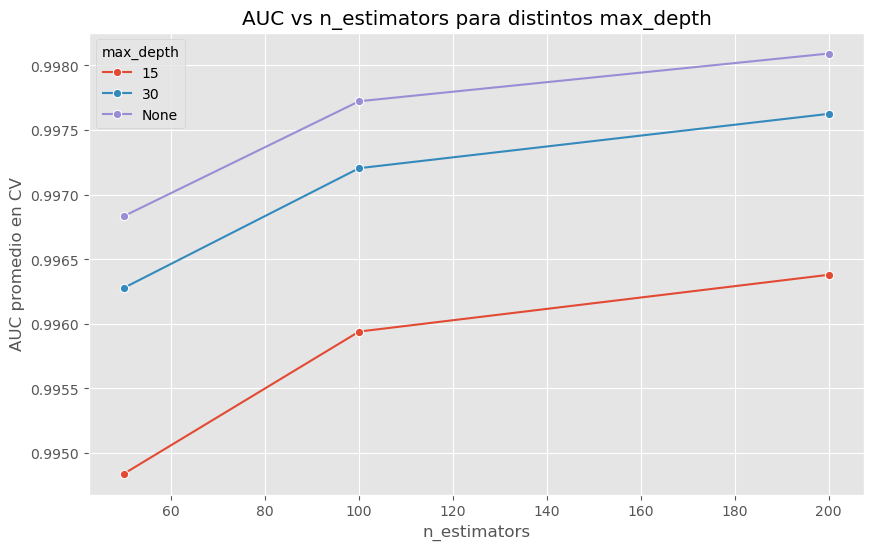

In [48]:
# Agrupa por n_estimators y max_depth
cv_results['param_max_depth'] = cv_results['param_max_depth'].astype(str)

grouped = cv_results.groupby(['param_n_estimators', 'param_max_depth']).mean_test_score.mean().reset_index()

# Plot
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(
    data=grouped,
    x='param_n_estimators',
    y='mean_test_score',
    hue='param_max_depth',
    marker='o'
)
plt.xlabel('n_estimators')
plt.ylabel('AUC promedio en CV')
plt.title('AUC vs n_estimators para distintos max_depth')
plt.legend(title='max_depth')
plt.grid(True)
plt.show()

In [49]:
# Aquí debe utilizar su modelo
# model = GaussianNB()
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_pca, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [50]:
y_train_pred = model.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = model.predict(X_test_pca)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8990
         1.0       1.00      1.00      1.00      8953

    accuracy                           1.00     17943
   macro avg       1.00      1.00      1.00     17943
weighted avg       1.00      1.00      1.00     17943

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      3810
         1.0       1.00      0.97      0.98      3880

    accuracy                           0.98      7690
   macro avg       0.99      0.98      0.98      7690
weighted avg       0.99      0.98      0.98      7690



In [51]:
# Aquí debe procesar las imagenes de pgm_kaggle_files


X_pca_kag = process_test_images(kaggle_patches, scaler, pca)

Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:07<00:00, 1057.61it/s]


In [52]:
# Predicción
y_kag = model.predict(X_pca_kag)

In [53]:
# Evaluate
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = model.predict(X_test_pca)
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)


Validation Accuracy: 0.9847854356306892


In [54]:
# Predicción + ID
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)

In [55]:
kaggle_hat.head()

,id,target_feature
2069,0,0
2527,1,0
3030,2,0
2576,3,0
4060,4,0


In [56]:
# Guardamos en un .csv para subir a kaggle
submission_name = 'submission_RandomForestClassifier'
kaggle_hat.to_csv(submission_name + '.csv', index=False)

### Baggin

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Árbol de decisión simple como base estimator
base_estimator = DecisionTreeClassifier(random_state=42)

# Metaestimador Bagging
bagging = BaggingClassifier(
    estimator=base_estimator,
    random_state=42
)

In [15]:
param_grid_bagging = {
    'n_estimators': [50, 100],
    'estimator__max_depth': [10, None],  # max_depth del árbol base
    'bootstrap': [True, False]
}

In [16]:
grid_bagging = GridSearchCV(
    estimator=bagging,
    param_grid=param_grid_bagging,
    cv=cv,
    scoring='roc_auc',   # o 'accuracy'
    n_jobs=-1,
    verbose=2
)

grid_bagging.fit(X_train_pca, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=50; total time= 5.4min
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=50; total time= 5.4min
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=50; total time= 5.5min
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=50; total time= 5.5min
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=50; total time= 5.6min
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=100; total time=10.7min
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=100; total time=10.9min
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=100; total time=11.0min
[CV] END bootstrap=True, estimator__max_depth=None, n_estimators=50; total time= 7.1min
[CV] END bootstrap=True, estimator__max_depth=None, n_estimators=50; total time= 7.5min
[CV] END bootstrap=True, estimator__max_depth=None, n_estimators=50; tota

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                                         random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'estimator__max_depth': [10, None],
                         'n_estimators': [50, 100]},
             scoring='roc_auc', verbose=2)

In [ ]:
print("Mejores hiperparámetros:", grid_bagging.best_params_)
print("Mejor AUC (CV):", grid_bagging.best_score_)

In [19]:
print("Mejores hiperparámetros:", grid_bagging.best_params_)
print("Mejor AUC (CV):", grid_bagging.best_score_)

scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)


# Predicción final en test
y_pred_bagging = grid_bagging.predict(X_test_pca)
print(classification_report(y_test, y_pred_bagging))

Mejores hiperparámetros: {'bootstrap': True, 'estimator__max_depth': 10, 'n_estimators': 100}
Mejor AUC (CV): 0.9976685819192138
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      3810
         1.0       0.99      0.98      0.99      3880

    accuracy                           0.99      7690
   macro avg       0.99      0.99      0.99      7690
weighted avg       0.99      0.99      0.99      7690

